# Building an Agent with LangGraph and Azure OpenAI: A Complete Guide

## Introduction

This tutorial will guide you through building an intelligent ordering system called BaristaBot using LangGraph and Azure OpenAI. The system will:
- Provide a natural language interface for cafe orders
- Maintain conversation state
- Handle complex order modifications
- Integrate with a menu system
- Process and validate orders

### Why LangGraph?

LangGraph is a powerful framework for building stateful, graph-based applications powered by language models. Key advantages include:
- Clear separation of concerns through nodes and edges
- Built-in state management
- Flexible routing between components
- Support for both synchronous and streaming operations
- Integration with various LLM providers

## Understanding LangGraph
LangGraph is a framework that helps you build applications with language models using a graph-based approach. Think of it like building blocks where each block has a specific job and they're connected in specific ways.

### Key Concepts


1. **Graphs**:  At its heart, LangGraph uses graphs. A graph is like a flowchart that shows how different parts of your application connect and work together.

2. **State**:  LangGraph keeps track of information as it moves through your application. This is called "state" and it's like a memory that holds things like:
   - The conversation history
   - Any important variables
   - The current status of the application

3. **Nodes**:  These are the building blocks of your application. Each node is like a worker that has a specific job. For example:
   - One node might talk to the language model
   - Another node might get input from the user
   - Another might update a database
   
   Python functions that encode the logic of your agents. They receive the current `State` as input, perform some computation or side-effect, and return an updated `State`.

4. **Edges**: These connect the nodes together and show how information flows between them. They determine things like:
   - What happens next after each step
   - When to stop or continue
   - Which path to take based on certain conditions

By composing `Nodes` and `Edges`, you can create complex, looping workflows that evolve the `State` over time. The real power, though, comes from how LangGraph manages that `State`. To emphasize: `Nodes` and `Edges` are nothing more than Python functions - they can contain an LLM or just good ol' Python code.

In short: `nodes` do the work. `edges` tell what to do next.

To start, install the LangGraph package:
```bash
%pip install langgraph
```

Let me show you a very simple example to illustrate these concepts:


In [1]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

# 1. First, we define what information we want to track (State)
class SimpleState(TypedDict):
    message: str  # Just tracking a single message for now
    
# 2. Create a simple node that processes messages
def message_processor(state: SimpleState) -> SimpleState:
    """A simple node that adds 'Processed: ' to messages"""
    return {"message": f"Processed: {state['message']}"}

# 3. Build the graph
graph = StateGraph(SimpleState) # Tell the graph what data can flow through it
graph.add_node("processor", message_processor)  # Add our node
graph.add_edge(START, "processor")  # Connect start to our node
graph.add_edge("processor", END)    # Connect our node to end

simple_graph = graph.compile() # Compile the graph


It can be helpful to visualise the graph you just defined. The following code renders the graph.

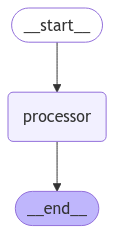

In [2]:
from IPython.display import Image, display

Image(simple_graph.get_graph().draw_mermaid_png())

## Setup and Installation

Requirements:
```bash
pip install langchain-openai
pip install azure-openai
```
### Configuration
Create a  `.env` file:

```python
AZURE_OPENAI_ENDPOINT="your_azure_endpoint"
AZURE_OPENAI_API_KEY="your_api_key"
OPENAI_API_VERSION="your_api_version"
```

In [3]:
from dotenv import load_dotenv
import os
from langchain_openai import AzureChatOpenAI

load_dotenv()

llm = AzureChatOpenAI(
    azure_deployment='gpt-4o',
    api_version=os.getenv("OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_KEY"),
    temperature=0.7,
    max_retries=3,
)

# test the llm
print(llm.invoke("Hello, how are you?"))


content="Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?" additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 13, 'total_tokens': 43, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_f3927aa00d', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': '

##  Building a BaristaBot Agent

### Introduction

BaristaBot is an interactive cafe ordering system that provides a natural language interface for customers to:

- Inquire about menu items
- Place and modify orders
- Confirm and process their orders

The system demonstrates key concepts of agent building using LangGraph including:

- State management
- Tool integration
- Conversation flow control
- Order processing

### System Components Overview

1. Statement Management System
    - Maintains conversation history
    - Tracks current order items
    - Handles order status
    - Manages completion flags

2. Conversation Handler
    - Processes user input
    - Generates appropriate responses
    - Routes to appropriate tools

3. Menu System
    - Provides menu information
    - validates menu items
    - handles menu inquires
    - Tracks availability

4. Order management System
    - Adds/removes items
    - Modifies orders
    - Confirms orders
    - Processes final orders

### Implementation Steps

### Step 1: Core State Definition

State is a fundamental concept for a LangGraph app. A state object is passed between every node and transition in the app. Here you define a state object, `OrderState`, that holds the conversation history, a structured order, and a flag indicating if the customer has finished placing their order. For simplicity, the "structure" in this order is just a list of strings, but this can be expanded to any Python data structure.

In Python, the LangGraph state object is a Python [dictionary](https://docs.python.org/3/library/stdtypes.html#dict). You can provide a schema for this dictionary by defining it as a [`TypedDict`](https://docs.python.org/3/library/typing.html#typing.TypedDict).

Let's first define how our system will maintain state:

In [4]:
from typing import TypedDict, Annotated, List
from langgraph.graph.message import add_messages

class OrderState(TypedDict):
    """State representing the customer's order conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[List[str], add_messages]

    # The customer's in-process order.
    order: List[str]

    # A flag indicating if the customer has finished placing their order.
    finished: bool

Note that
- `Annotated` is a special type from the typing module that allows you to add extra metadata to type hints. e.g. 
    ```python
    UserId = Annotated[int, 'User ID must be an integer']
    user_id: UserId = 123
    ```
- `messages` uses `add_messages` annotation for automatic message appending
- `order` tracks ordered items and their modifiers
- `finished` controls conversation termination




### Step 2: System Instructions

Define the system prompt for the LLM.

In [5]:
# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.

BARISTABOT_SYSINT = (
    "system",  # 'system' indicates the message is a system instruction.
    """You are BaristaBot, an interactive cafe ordering system. A human will talk to you about the 
    available products you have and you will answer any questions about menu items (and only about 
    menu items - no off-topic discussion, but you can chat about the products and their history).
    The customer will place an order for 1 or more items from the menu, which you will structure 
    and send to the ordering system after confirming the order with the human.
    
    Add items to the customer's order with add_to_order, and reset the order with clear_order. 
    To see the contents of the order so far, call get_order (this is shown to you, not the user) 
    Always confirm_order with the user (double-check) before calling place_order. Calling confirm_order will display the order items to the user and returns their response to seeing the list. Their response may contain modifications. 
    Always verify and respond with drink and modifier names from the MENU before adding them to the order. 
    If you are unsure a drink or modifier matches those on the MENU, ask a question to clarify or redirect. 
    You only have the modifiers listed on the menu.
    Once the customer has finished ordering items, Call confirm_order to ensure it is correct then make 
    any necessary updates and then call place_order. Once place_order has returned, thank the user and 
    say goodbye!
    """
)

# This is the message with which the system opens the conversation.
WELCOME_MSG = "Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?"

This instruction:

- Defines the bot's role and capabilities
- Sets conversation boundaries
- Establishes interaction rules
- Ensures consistent behavior


### Step 3. Building Basic Chat Interface

Before diving into the code, let's understand what we need to build and why.

#### Components Needed:

1. **Chatbot Node**
    - **Purpose**: Central processing unit that handles LLM interactions
    - **Responsibilities**:
        - Processes incoming messages using Azure OpenAI
        - Manages initial greetings
        - Formats responses correctly
        - Manages conversation context
    - **Why**: We need this to handle the core conversation logic and LLM interactions

2. **Human Node**
    - **Purpose**: manages user interaction interface
    - **Responsibilities**:
        - Displays bot messages to user
        - Captures user input
        - Handles exit commands
        - Updates conversation state
    - **Why**: Creates separation between user interaction and bot processing

3. **Router**
    - **Purpose**: Controls conversation flow
    - **Responsibilities**:
        - Determines next steps based on state
        - Handles conversation endings
        - Manages transitions between nodes
    - **Why**: Ensures proper flow control and state transitions

#### How They Work Together
1. Flow Sequence

    START -> Chatbot (Welcome) -> Human (Input) -> Chatbot (Response) -> Human (Input) -> ... -> END

2. State Updates:
    - Each node receives current state
    - Process its part
    - Returns updated state
    - Never modifies existing state

#### Implementation Details

1. Chatbot node implementation


In [6]:
from langchain_core.messages import AIMessage, HumanMessage

# chatbot node
def chatbot_node(state: OrderState) -> OrderState:
    """
    Main conversation processor using Azure OpenAI.
    
    State Input:
        - messages: Current conversation history
        - order: Current order items
        - finished: Conversation status
        
    State Output:
        - Updated state with new bot message
    """
    # check if this is the start of the conversation
    if not state["messages"]:
        # send welcome message
        return {"messages": [AIMessage(content=WELCOME_MSG)]}
    
    # process existing conversation
    try:
        # add system instructions and conversation history
        full_history = [BARISTABOT_SYSINT] + state["messages"]
        # get llm response
        response = llm.invoke(full_history)

        # update the state with response
        return state | {"messages": [response]}
    
    except Exception as e:
        # handle errors gracefully
        error_msg = "I apologize, I'm having trouble right now. Could you try again?"
        return state | {"messages": [AIMessage(content=error_msg)]}

2. Human node implementation

In [7]:
def human_node(state: OrderState) -> OrderState:
    """
    Handles user interaction.
    
    State Input:
        - messages: Contains last bot message to display
        - finished: Current conversation status
        
    State Output:
        - Updated state with new user message
        - Updated finished status if ending
    """
    # display the last bot message
    last_msg = state['messages'][-1]
    print(f"Model: {last_msg.content}")

    # get user input with error handling
    try:
        user_input = input("User: ").strip()
        
        # check for exit command
        if user_input.lower() in ['q', 'quit', 'exit', 'goodbye', 'bye']:
            return state | {
                "messages": [HumanMessage(content=user_input)],
                "finished": True
            }
        
        # regular message processing
        return state | {
            "messages": [HumanMessage(content=user_input)]
        }

    except Exception as e:
        return state | {
            "messages": [HumanMessage(content='quit')],
            "finished": True
        }

3. Router implementation

In [8]:
from typing import Literal
def router_function(state: OrderState) -> Literal["chatbot", "__end__"]:
    """
    Determines next node in conversation flow.
    
    Routing Logic:
        - END if conversation finished
        - chatbot for continuing conversation
    """ 
    if state.get("finished", False):
        return END
    else:
        return "chatbot"

4. Putting all together

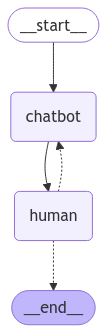

In [9]:
def create_basic_chat():
    """Create the basic chat graph structure"""
    graph = StateGraph(OrderState)

    # add our defined nodes
    graph.add_node("chatbot", chatbot_node)
    graph.add_node("human", human_node)

    # add edges
    graph.add_edge(START, "chatbot") # START -> chatbot
    graph.add_edge("chatbot", "human") # chatbot -> human

    # add conditional routing
    graph.add_conditional_edges(
        "human",            # from human node
        router_function,    # user router function
        {END, "chatbot"}    # Possible destinations
    )

    return graph.compile()

chat_with_human_graph = create_basic_chat()
Image(chat_with_human_graph.get_graph().draw_mermaid_png())

5. Running the graph

In [20]:
def test_chat():
    """Test the basic chat implementation."""
    graph = create_basic_chat()
    
    # Initial state
    state = {
        "messages": [],      # Empty conversation
        "order": [],        # No orders yet
        "finished": False   # Conversation active
    }
    
    try:
        # Run the conversation
        final_state = graph.invoke(state)
        
        # Show results
        print("\nConversation Summary:")
        print(f"Total Messages: {len(final_state['messages'])}")
        print(f"Final Status: {'Completed' if final_state['finished'] else 'Active'}")
        
        # Print conversation history
        print("\nConversation History:")
        for msg in final_state["messages"]:
            # Check message type to determine if it's from bot or user
            if isinstance(msg, AIMessage):
                print(f"Bot: {msg.content}")
            else:
                print(f"User: {msg.content}")
        
    except Exception as e:
        print(f"Error in conversation: {e}")

test_chat()

Model: Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?
Model: Sure! Here's our menu:

**Drinks:**
1. Espresso
2. Americano
3. Latte
4. Cappuccino
5. Mocha
6. Macchiato

**Modifiers:**
1. Extra Shot
2. Almond Milk
3. Soy Milk
4. Vanilla Syrup
5. Caramel Syrup
6. Whipped Cream

Would you like to know more about any of these items or place an order?

Conversation Summary:
Total Messages: 4
Final Status: Completed

Conversation History:
Bot: Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?
User: what do you have?
Bot: Sure! Here's our menu:

**Drinks:**
1. Espresso
2. Americano
3. Latte
4. Cappuccino
5. Mocha
6. Macchiato

**Modifiers:**
1. Extra Shot
2. Almond Milk
3. Soy Milk
4. Vanilla Syrup
5. Caramel Syrup
6. Whipped Cream

Would you like to know more about any of these items or place an order?
User: q


### Step 4. Integrate with Menu

BaristaBot currently has no awareness of the available items at the cafe, so it will hallucinate a menu. One option would be to hard-code a menu into the system prompt. This would work well, but to simulate a system where the menu is more dynamic and could respond to fluctuating stock levels, you will put the menu into a custom tool.

There are two types of tools that this system will use. Stateless tools that can be run automatically, and stateful tools that modify the order. The "get current menu" tool is stateless, in that it does not make any changes to the live order, so it can be called automatically.

In a LangGraph app, you can annotate Python functions as tools by applying the `@tools` annotation.

In [11]:
from langchain_core.tools import tool

@tool
def get_menu() -> str:
    """Provide the latest up-to-date menu."""
    # Note that this is just hard-coded text, but you could connect this to a live stock database

    return """
        MENU:
    Coffee Drinks:
    - Espresso
    - Americano
    - Cold Brew

    Coffee Drinks with Milk:
    - Latte
    - Cappuccino
    - Cortado
    - Macchiato
    - Mocha
    - Flat White

    Tea Drinks:
    - English Breakfast Tea
    - Green Tea
    - Earl Grey

    Tea Drinks with Milk:
    - Chai Latte
    - Matcha Latte
    - London Fog

    Other Drinks:
    - Steamer
    - Hot Chocolate

    Modifiers:
    - Milk options: Whole, 2%, Oat, Almond, 2% Lactose Free; Default option: whole
    - Espresso shots: Single, Double, Triple, Quadruple; default: Double
    - Caffeine: Decaf, Regular; default: Regular
    - Hot-Iced: Hot, Iced; Default: Hot
    - Sweeteners (option to add one or more): vanilla sweetener, hazelnut sweetener, caramel sauce, chocolate sauce, sugar free vanilla sweetener
    
    Special requests: any reasonable modification that does not involve items not on the menu, for example: 'extra hot', 'one pump', 'half caff', 'extra foam', etc.

    "dirty" means add a shot of espresso to a drink that doesn't usually have it, like "Dirty Chai Latte".
    "Regular milk" is the same as 'whole milk'.
    "Sweetened" means add some regular sugar, not a sweetener.

    Soy milk has run out of stock today, so soy is not available.
    """

Now add the new tool to the graph. The `get_menu` tool is wrapped in a [`ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode) that handles calling the tool and passing the response as a message through the graph. The tools are also bound to the `llm` object so that the underlying model knows they exist. As you now have a different `llm` object to invoke, you need to update the `chatbot` node so that it is aware of the tools.


In [12]:
from langgraph.prebuilt import ToolNode

# Define the tools and create a "tools" node.
tools = [get_menu]
tool_node = ToolNode(tools)

# Attach the tools to the model so that it knows what it can call.
llm_with_tools = llm.bind_tools(tools)

Now we need to update our chatbot node to use the tools.

In [13]:
def chatbot_with_tools(state: OrderState) -> OrderState:
    """
    Enhanced chatbot that can use menu tools.
    """
    defaults = {"order": [], "finished": False}

    if not state["messages"]:
        return defaults | {"messages": [AIMessage(content=WELCOME_MSG)]}
    
    try:
        # add system instructions and conversation history
        full_history = [BARISTABOT_SYSINT] + state["messages"]
        # get llm response
        response = llm_with_tools.invoke(full_history)

        # update the state with response
        return state | {"messages": [response]}
    
    except Exception as e:
        # handle errors gracefully
        error_msg = "I apologize, I'm having trouble right now. Could you try again?"
        return state | {"messages": [AIMessage(content=error_msg)]}
    
def maybe_route_to_tools(state: OrderState) -> Literal["human", "tools"]:
    """
    Route between human or tool nodes, depending if a tool call is made.
    """
    msgs = state.get("messages", [])
    if not msgs:
        raise ValueError(f"No messges found when parsing state: {state}")
    
    # only route based on the last message
    msg = msgs[-1]

    # when the chatbot returns tool_calls, route to the "tools" node.
    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        return "tools"
    else: 
        return "human"    

Update the graph to inlude menu tools:

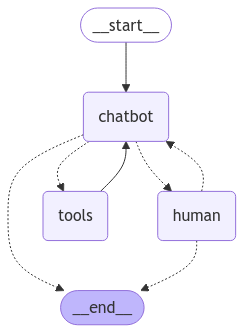

In [22]:
def create_graph_with_meue():
    """Create the enchanced graph with menu functionalities"""
    graph = StateGraph(OrderState)

    graph.add_node("chatbot", chatbot_with_tools)
    graph.add_node("human", human_node)
    graph.add_node("tools", tool_node)

    graph.add_edge(START, "chatbot")

    # chatbot may go to tools, or human
    graph.add_conditional_edges(
        "chatbot",
        maybe_route_to_tools,
        {"human", "tools"}
    )

    # tools alwasys go back to chatbot
    graph.add_edge("tools", "chatbot")

    # human may go to chatbot or exist
    graph.add_conditional_edges(
        "human",
        router_function,
        {END, "chatbot"}
    )

    return graph.compile()

graph_with_meue = create_graph_with_meue()
Image(graph_with_meue.get_graph().draw_mermaid_png())


Test menu integration:

In [24]:
def test_menu_chat():
    """Test chat with menu"""
    print("\nTesting BaristaBot with menu integration...")

    graph = create_graph_with_meue()

    initial_state = {
        "messages": [],
        "order": [],
        "finished": False
    }

    try: 
        final_state = graph.invoke(initial_state, {
            'recursion_limit': 100 # Increase recursion limit for long conversations (default is 25)
        })

        print("\nConversation Summary:")
        print(f"Total Messages: {len(final_state['messages'])}")

        print("\nConversation History:")
        for msg in final_state["messages"]:
            print(f"{type(msg).__name__}: {msg.content}")
    except Exception as e:
        print(f"Error in conversation: {e}")

test_menu_chat()


Testing BaristaBot with menu integration...
Model: Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?
Model: Here's our menu:

**Coffee Drinks:**
- Espresso
- Americano
- Cold Brew

**Coffee Drinks with Milk:**
- Latte
- Cappuccino
- Cortado
- Macchiato
- Mocha
- Flat White

**Tea Drinks:**
- English Breakfast Tea
- Green Tea
- Earl Grey

**Tea Drinks with Milk:**
- Chai Latte
- Matcha Latte
- London Fog

**Other Drinks:**
- Steamer
- Hot Chocolate

**Modifiers:**
- **Milk options:** Whole, 2%, Oat, Almond, 2% Lactose Free (Default: Whole)
- **Espresso shots:** Single, Double, Triple, Quadruple (Default: Double)
- **Caffeine:** Decaf, Regular (Default: Regular)
- **Hot-Iced:** Hot, Iced (Default: Hot)
- **Sweeteners:** Vanilla sweetener, Hazelnut sweetener, Caramel sauce, Chocolate sauce, Sugar free vanilla sweetener

**Special Requests:**
- Any reasonable modification that does not involve items not on the menu, e.g., "extra hot", "one pump", "half caff", "e

### Step 5. Order Management

To build up an order during chat conversation, we need tools that can modify the order state. 

In LangGraph/LangChain, `@tool` decorated functions serve as schemas or interfaces that tell the LLM what tools are available and how to use them. More specifically, they tell the LLM:
- What actions are available
- What arguments they require
- What they return
- What they do (through descriptions)

Think of tools as a menu for the LLM - they describe what actions are possible, but don't execute them - that's done in the nodes.


Firs, let's understand what order management tools we need:

In [30]:
from collections.abc import Iterable
from langchain_core.messages.tool import ToolMessage
from random import randint

@tool
def add_to_order(drink: str, 
                 modifiers: Iterable[str]) -> str:
     """Adds the specified drink to the customer's order, including any modifiers.

    Returns:
        Updated order summary
    """

@tool
def confirm_order() -> str:
    """Asks the customer if the order is correct.

    Returns:
      The user's free-text response.
    """

@tool
def get_order() -> str:
    """Returns the users order so far. One item per line."""


@tool
def clear_order():
    """Removes all items from the user's order."""


@tool
def place_order() -> int:
    """Sends the order to the barista for fulfillment.

    Returns:
      The estimated number of minutes until the order is ready.
    """

Next, we need a node that handles these order operations:

In [31]:
def order_node(state: OrderState) -> OrderState:
    """The ordering node. This is where the order state is manipulated."""
    tool_msg = state.get("messages", [])[-1]
    order = state.get("order", [])
    outbound_msgs = [] # Messages to send to the user
    order_placed = False

    for tool_call in tool_msg.tool_calls:
        
        if tool_call['name'] == 'add_to_order':
            # each order item is just a string. This is where it assembled as "drink (modifiers, ...)".
            modifier = tool_call["args"]["modifiers"]
            modifier_str = ", ".join(modifier) if modifier else "no modifiers"

            order.append(f'{tool_call["args"]["drink"]} ({modifier_str})')
            response = "\n".join(order)

        elif tool_call['name'] == 'confirm_order':
            # We could entrust the LLM to do order confirmation, but it is a good practice to
            # show the user the exact data that comprises their order so that what they confirm
            # precisely matches the order that goes to the kitchen - avoiding hallucination
            # or reality skew.

            # In a real scenario, this is where you would connect your POS screen to show the
            # order to the user.
            print("Your order:")
            if not order:
                print(" (no items)")
            
            for drink in order:
                print(f" {drink}")

            response = input("Is this correct? ")

        elif tool_call['name'] == 'get_order':
            
            response = "\n".join(order) if order else "(no order)"

        elif tool_call['name'] == 'clear_order':
            
            order.clear()
            response = None

        elif tool_call['name'] == 'place_order':

            order_text = "\n".join(order)
            print("Sending order to kitchen!")
            print(order_text)
            order_placed = True

            response = f"Your order has been placed. It will be ready in {randint(1, 5)} minutes."

        else:
            raise NotImplementedError(f"Unknown tool call: {tool_call['name']}")
        
        # record the tool resutls as tool messages
        outbound_msgs.append(
            ToolMessage(
                content = response,
                name = tool_call['name'],
                tool_call_id = tool_call['id']
            )
        )

    return {
        "messages": outbound_msgs,
        "order": order,
        "finished": order_placed
    }

Now update our graph to incorporate order management:

In [36]:
def maybe_route_to_tools(state: OrderState) -> str:
    """Route between chat and tool nodes based on state."""
    msgs = state.get("messages", [])
    if not msgs:
        raise ValueError(f"No messages found when parsing state: {state}")

    msg = msgs[-1]

    if state.get('finished', False):
        # when an order is placed, exist the app.
        # The system instruction indicates that the chatbot should say thanks and goodbye at this point,
        # so we can exit cleanly
        return END

    elif hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        # Route to 'tools' node for any automated tool calls first
        if any(
            tool["name"] in tool_node.tools_by_name.keys() for tool in msg.tool_calls
        ):
            return "tools"
        else:
            return "ordering"   
    else:
        return "human"

This time, we add two sets of tools: one for ordering, and the other for getting the menu. The llm needs to know about thess tools. 

I designed the `create_chatbot_node` factory function to make the chatbot architecture more modular and configurable.

In [37]:
from typing import Callable
from langchain_core.language_models import BaseChatModel

def create_chatbot_node(
        llm_with_tools: BaseChatModel,
        system_prompt: tuple = BARISTABOT_SYSINT,
        welcome_message: str = WELCOME_MSG
) -> Callable[[OrderState], OrderState]:
    
    """Creates a chatbot node function with the specified LLM"""
    def chatbot_with_tools(state: OrderState) -> OrderState:
        """The chatbot node that uses the configured LLM"""
        defaults = {"order": [], "finished": False}
        
        if not state["messages"]:
            return defaults | {"messages": [AIMessage(content=welcome_message)]}
            
        try:
            full_history = [system_prompt] + state["messages"]
            response = llm_with_tools.invoke(full_history)
            return state | {"messages": [response]}
            
        except Exception as e:
            error_msg = "I apologize, I'm having trouble right now. Could you try again?"
            return state | {"messages": [AIMessage(content=error_msg)]}
            
    return chatbot_with_tools

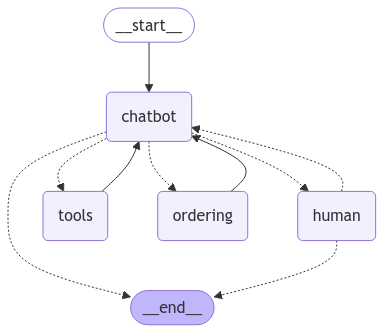

In [38]:
# create graph with order management:
def create_order_graph():

    # initialize the graph
    graph = StateGraph(OrderState)

    # Define tool sets
    # menu tools will be invoked automatically by the ToolNode
    menu_tools = [get_menu]

    # Order-tools will be handled by the order node.
    order_tools = [
        add_to_order,
        confirm_order,
        get_order,
        clear_order,
        place_order
    ]

    # bind the tools to the LLM, so that LLM knows what it can call
    llm_with_tools = llm.bind_tools(menu_tools + order_tools)
    
    chatbot_node = create_chatbot_node(llm_with_tools)
    # add nodes
    graph.add_node("chatbot", chatbot_node) # llm_with_tools from the last line is used here
    graph.add_node("human", human_node)
    graph.add_node("tools", ToolNode(menu_tools))
    graph.add_node("ordering", order_node)

    # add edges
    graph.add_edge(START, "chatbot") # START -> chatbot
    graph.add_conditional_edges(
        "chatbot",
        maybe_route_to_tools
    ) # chatbot -> tools or human or ordering or END
    graph.add_edge("tools", "chatbot") # tools -> chatbot
    graph.add_edge("ordering", "chatbot") # ordering -> chatbot
    graph.add_conditional_edges(
        "human",
        router_function
    ) # human -> chatbot or END

    return graph.compile()

order_graph = create_order_graph()
Image(order_graph.get_graph().draw_mermaid_png())


#### Example Usage

In [39]:
def test_order_chat():

    # initialize the graph
    graph = create_order_graph()
    initial_state = {
        "messages": [],
        "order": [],
        "finished": False
    }

    try:
        final_state = graph.invoke(initial_state, {
            'recursion_limit': 100
        })

        print("\nConversation Summary:")
        print(f"Total Messages: {len(final_state['messages'])}")

        print("\nConversation History:")

        for msg in final_state["messages"]:
            print(f"{type(msg).__name__}: {msg.content}")
    except Exception as e:
        print(f"Error in conversation: {e}")

test_order_chat()

Model: Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?


Model: Great! Here's our menu:

**Coffee Drinks:**
- Espresso
- Americano
- Cold Brew

**Coffee Drinks with Milk:**
- Latte
- Cappuccino
- Cortado
- Macchiato
- Mocha
- Flat White

**Tea Drinks:**
- English Breakfast Tea
- Green Tea
- Earl Grey

**Tea Drinks with Milk:**
- Chai Latte
- Matcha Latte
- London Fog

**Other Drinks:**
- Steamer
- Hot Chocolate

**Modifiers:**
- Milk options: Whole, 2%, Oat, Almond, 2% Lactose Free (default: Whole)
- Espresso shots: Single, Double, Triple, Quadruple (default: Double)
- Caffeine: Decaf, Regular (default: Regular)
- Hot/Iced: Hot, Iced (default: Hot)
- Sweeteners: Vanilla, Hazelnut, Caramel sauce, Chocolate sauce, Sugar-free vanilla

Special requests are welcome as long as they involve items on the menu.

What would you like to order?
Model: Just to confirm, would you like to order a Matcha Latte? If so, do you have any specific modifiers or special requests for it?
Model: I've added a Matcha Latte to your order with no modifiers.

Would you l